## Network Analysis

To create a graph from your DataFrame using NetworkX, where each row represents a customer (we make this assumption here) and the columns represent categorical variables encoded as boolean values, you can follow these steps:
- Import and prepare the data 
- Create a graph
- Add nodes to the graph
- Add edges to the graph 
- Visualize the graph
- Export the graph to CSV (for example to use it as an input in gephi)

## Importing packages and data

In [1]:
# %pip install networkx


In [2]:
import pandas as pd 
import numpy  as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [3]:
pd.options.display.float_format = '{:.2f}'.format

In [4]:
hotel_df = pd.read_csv("data/output/hotel_dataset_cleaned.csv")

In [5]:
hotel_df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,hotel
0,0,342,2015,July,27,1,0,0,2,0.00,...,-1.00,-1.00,0,Transient,0.00,0,0,Check-Out,2015-07-01,Resort hotel
1,0,737,2015,July,27,1,0,0,2,0.00,...,-1.00,-1.00,0,Transient,0.00,0,0,Check-Out,2015-07-01,Resort hotel
2,0,7,2015,July,27,1,0,1,1,0.00,...,-1.00,-1.00,0,Transient,75.00,0,0,Check-Out,2015-07-02,Resort hotel
3,0,13,2015,July,27,1,0,1,1,0.00,...,304.00,-1.00,0,Transient,75.00,0,0,Check-Out,2015-07-02,Resort hotel
4,0,14,2015,July,27,1,0,2,2,0.00,...,240.00,-1.00,0,Transient,98.00,0,1,Check-Out,2015-07-03,Resort hotel


## Preparing data

We only take a (random) subset of our rows to reduce complexity and processing time

In [6]:
# Define the number of rows to select
num_rows = 200
random_seed = 42

# take a sample random subset of rows
hotel_df_sample = hotel_df.sample(n=num_rows,random_state=random_seed).reset_index(drop=True)

We only take a subset of our columns to reduce complexity and processing time

In [7]:
hotel_df_sample.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'hotel'],
      dtype='object')

In [8]:
num_features = ["LeadTime","ArrivalDateWeekNumber","ArrivalDateDayOfMonth",
                "StaysInWeekendNights","StaysInWeekNights","Adults","Children",
                "Babies","PreviousCancellations",
                "PreviousBookingsNotCanceled", "ADR"]

cat_features = ["hotel","ArrivalDateMonth","Meal","MarketSegment", "IsRepeatedGuest", "RequiredCarParkingSpaces", "TotalOfSpecialRequests",
                "DistributionChannel","ReservedRoomType","DepositType","CustomerType"]


In [9]:
hotel_df_sample_subset = hotel_df_sample.loc[:, num_features + cat_features]

In [10]:
hotel_df_sample_subset.head()

,LeadTime,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,...,ArrivalDateMonth,Meal,MarketSegment,IsRepeatedGuest,RequiredCarParkingSpaces,TotalOfSpecialRequests,DistributionChannel,ReservedRoomType,DepositType,CustomerType
0,405,27,4,0,2,2,0.00,0,0,0,...,July,HB,Offline TA/TO,0,0,0,TA/TO,A,No Deposit,Transient-Party
1,74,17,23,2,2,2,1.00,0,0,0,...,April,BB,Online TA,0,0,2,TA/TO,A,No Deposit,Transient
2,247,44,28,1,2,2,0.00,0,0,0,...,October,BB,Groups,0,0,0,TA/TO,A,Non Refund,Transient
3,157,18,1,1,3,2,0.00,0,0,0,...,May,BB,Groups,0,0,0,TA/TO,A,Non Refund,Transient
4,3,1,5,0,1,2,0.00,0,0,7,...,January,SC,Online TA,1,0,1,TA/TO,A,No Deposit,Transient


In [11]:
# Standardize the numeric features
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(hotel_df_sample_subset[num_features])

## Similarity Functions


To use both numeric and categorical variables in your similarity calculation, you can combine different similarity metrics for each type of variable and then aggregate them into an overall similarity score. Here's a general approach:

1. Calculate Similarity for Categorical Variables: For categorical variables, you can use Jaccard similarity or another appropriate metric.

2. Calculate Similarity for Numeric Variables: For numeric variables, you can use cosine similarity, Pearson correlation coefficient, or another suitable metric.

3. Combine Similarity Scores: After obtaining similarity scores for both types of variables, you can combine them into an overall similarity score using a weighted average or another aggregation method. The weights can be adjusted based on the importance of each type of variable.

In [12]:
# Calculate cosine similarity for numeric features
def numeric_similarity(customer1, customer2):
    index1 = hotel_df_sample_subset.index.get_loc(customer1)
    index2 = hotel_df_sample_subset.index.get_loc(customer2)
    return cosine_similarity([numeric_features_scaled[index1]], [numeric_features_scaled[index2]])[0, 0]

# Calculate Jaccard similarity for categorical features
def categorical_similarity(customer1, customer2):
    features_customer1 = set(hotel_df_sample_subset.loc[customer1, cat_features])
    features_customer2 = set(hotel_df_sample_subset.loc[customer2, cat_features])
    common_features = len(features_customer1.intersection(features_customer2))
    total_features = len(features_customer1.union(features_customer2))
    return common_features / total_features

# Combine similarity scores using weighted average
def combined_similarity(customer1, customer2, numeric_weight=0.5):
    numeric_sim = numeric_similarity(customer1, customer2)
    cat_sim = categorical_similarity(customer1, customer2)
    return numeric_weight * numeric_sim + (1 - numeric_weight) * cat_sim

### Create Graph, nodes and edges

In [13]:
# Create an empty graph
G = nx.Graph()

In [14]:
# Add nodes to the graph 
customers = hotel_df_sample_subset.index
G.add_nodes_from(customers)

In [15]:
# Add edges to the graph based on similarity score
threshold = 0.6
for customer1 in customers:
    for customer2 in customers:
        if customer1 < customer2:  # Ensure not to repeat pairs
            similarity = combined_similarity(customer1, customer2)
            if similarity > threshold:
                G.add_edge(customer1, customer2, weight=similarity)

Here's a breakdown of what it does:

- **Iteration over pairs of customers**: It iterates over each pair of customers using nested loops, where customer1 and customer2 represent the indices of the customers in the DataFrame.

- **Jaccard Similarity Calculation**: For each pair of customers, it calculates the Jaccard similarity between their features. Jaccard similarity is a measure of similarity between two sets and is defined as the size of the intersection divided by the size of the union of the sets.

- **Adding Edge**: If the calculated Jaccard similarity between two customers exceeds a specified threshold (0.5 in this case), an edge is added between them in the graph (G). The weight of the edge is set to the calculated similarity.

- **Avoiding Duplicate Pairs**: The condition if i < j ensures that each pair of customers is considered only once, avoiding duplicate pairs.

In summary, this code calculates the Jaccard similarity between pairs of customers based on their features and adds edges between customers whose similarity exceeds a certain threshold to create a graph representation of customer similarity.

Jaccard similarity is commonly used in various fields such as data mining, text analysis, recommendation systems, and bioinformatics.
Other similarity measures commonly used include:
- **Cosine similarity**: Measures the cosine of the angle between two vectors in a multi-dimensional space. It is often used in text mining and information retrieval.
- **Euclidean distance**: Measures the straight-line distance between two points in a multi-dimensional space. It is widely used in clustering algorithms and machine learning.
- **Pearson correlation coefficient**: Measures the linear correlation between two variables. It is commonly used in statistics and data analysis to quantify the strength and direction of a relationship between variables.
Each similarity measure has its own advantages and disadvantages, and the choice of measure depends on the specific application and the nature of the data being analyzed.


**Remark**

enumerate(customers) is a Python built-in function that returns an iterator which yields pairs of elements. The first element of each pair is an index, and the second element is the corresponding value from the iterable customers.

Here's how it works:

- Indexing: The enumerate() function assigns an index to each element in the iterable customers. The indexing starts from 0 by default, but you can specify a start value if needed.

- Iterator: enumerate() returns an iterator that generates these index-value pairs one by one.


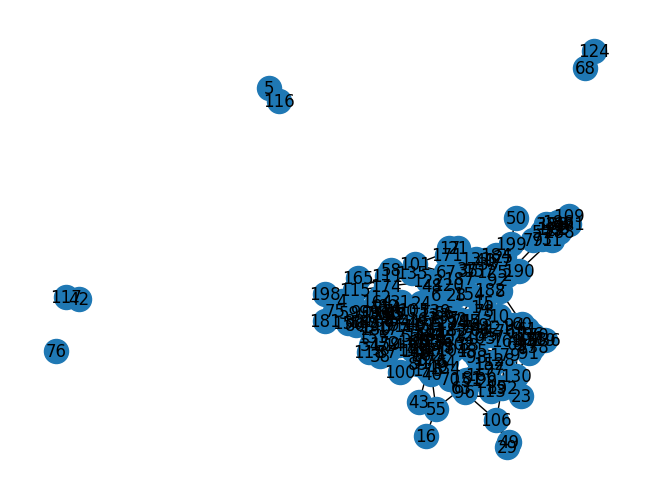

In [16]:
# Draw the graph with a specified layout algorithm (e.g., spring layout) and seed
pos = nx.spring_layout(G, seed=random_seed)
nx.draw(G, pos, with_labels=True)

# Display the graph
plt.show()

**Remark**

The layout of a graph refers to the arrangement of nodes and edges in the visualization. Different layout algorithms in NetworkX (such as spring layout, circular layout, etc.) provide different strategies for arranging nodes and edges to make the graph visually appealing and informative.

When you visualize a graph without specifying a seed for the layout algorithm, NetworkX uses a random seed by default. This means that each time you run the visualization code without a seed, the layout algorithm starts with a different random state, resulting in a different arrangement of nodes and edges. However, the underlying graph structure (nodes and edges) remains the same.

Setting a seed for the layout algorithm ensures that the random initialization process is the same each time you run the code, leading to consistent layout arrangements across different runs. This is particularly useful for reproducibility and comparing visualizations.

On the other hand, if you don't set a seed and the graph structure remains the same (same nodes and edges), you will observe the same graph topology but with different layout arrangements due to the random initialization of the layout algorithm.

### Evaluation

In [17]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
print("Degree Centrality:", degree_centrality)

Degree Centrality: {0: 0.04020100502512563, 1: 0.05025125628140704, 2: 0.03015075376884422, 3: 0.02512562814070352, 4: 0.005025125628140704, 5: 0.005025125628140704, 6: 0.03015075376884422, 7: 0.05527638190954774, 8: 0.05527638190954774, 9: 0.05527638190954774, 10: 0.05527638190954774, 11: 0.035175879396984924, 12: 0.02512562814070352, 13: 0.07035175879396985, 14: 0.08040201005025126, 15: 0.03015075376884422, 16: 0.005025125628140704, 17: 0.010050251256281407, 18: 0.11557788944723618, 19: 0.03015075376884422, 20: 0.01507537688442211, 21: 0.010050251256281407, 22: 0.08542713567839195, 23: 0.01507537688442211, 24: 0.05025125628140704, 25: 0.04522613065326633, 26: 0.04522613065326633, 27: 0.06030150753768844, 28: 0.02512562814070352, 29: 0.010050251256281407, 30: 0.04522613065326633, 31: 0.05025125628140704, 32: 0.03015075376884422, 33: 0.04522613065326633, 34: 0.03015075376884422, 35: 0.035175879396984924, 36: 0.04020100502512563, 37: 0.035175879396984924, 38: 0.02512562814070352, 39: 0.

In [18]:
# Calculate avarage degree centrality 
avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
print("Average Degree Centrality:", avg_degree_centrality)

Average Degree Centrality: 0.04010050251256283


In [19]:
# Sort nodes by degree centrality
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Print top ten nodes by degree centrality
print("Top Ten Nodes by Degree Centrality:")
for node, centrality in sorted_degree_centrality[:10]:
    print(f"Node {node}: Degree Centrality = {centrality}")

Top Ten Nodes by Degree Centrality:
Node 18: Degree Centrality = 0.11557788944723618
Node 177: Degree Centrality = 0.09547738693467336
Node 93: Degree Centrality = 0.09045226130653267
Node 139: Degree Centrality = 0.09045226130653267
Node 183: Degree Centrality = 0.09045226130653267
Node 22: Degree Centrality = 0.08542713567839195
Node 71: Degree Centrality = 0.08542713567839195
Node 160: Degree Centrality = 0.08542713567839195
Node 193: Degree Centrality = 0.08542713567839195
Node 14: Degree Centrality = 0.08040201005025126


In [20]:
# Find communities using Louvain algorithm
communities = nx.community.greedy_modularity_communities(G)

# Alternatively
# Find communities using Louvain algorithm with resolution parameter
# communities = nx.community.best_partition(G, resolution=1.0)

# Print out each community along with its constituent nodes.
for i, community in enumerate(communities):
    print(f"Community {i+1}: {community}")

Community 1: frozenset({128, 132, 139, 13, 142, 14, 144, 145, 143, 15, 17, 149, 148, 153, 26, 28, 30, 31, 163, 36, 165, 167, 40, 168, 171, 173, 45, 174, 176, 51, 54, 183, 56, 58, 187, 66, 194, 67, 69, 198, 71, 74, 89, 95, 101, 102, 103, 111, 112, 115, 122, 126})
Community 2: frozenset({129, 3, 4, 133, 6, 135, 9, 137, 140, 12, 146, 18, 150, 22, 24, 155, 156, 160, 161, 164, 166, 39, 44, 46, 48, 177, 179, 180, 181, 53, 59, 193, 65, 197, 75, 80, 82, 83, 84, 86, 90, 93, 98, 99, 105, 108, 110, 114, 120, 121, 127})
Community 3: frozenset({130, 134, 10, 141, 16, 19, 20, 23, 152, 151, 29, 162, 43, 175, 49, 178, 52, 55, 185, 61, 62, 63, 64, 192, 70, 81, 85, 91, 94, 96, 104, 106, 113})
Community 4: frozenset({0, 2, 131, 199, 8, 77, 21, 25, 154, 92, 157, 33, 35, 37, 41, 50, 182, 184, 125})
Community 5: frozenset({73, 11, 78, 79, 88, 27, 32, 172, 109, 47, 57, 186, 188, 189, 190, 191})
Community 6: frozenset({97, 1, 196, 7, 136, 169, 138, 170, 107, 119, 60, 158})
Community 7: frozenset({34, 195, 100

Alternatively, you can find communities using Louvain algorithm with resolution parameter

- communities = nx.community.best_partition(G, resolution=1.0)

In this example, you can adjust the resolution parameter to influence the number and size of the communities found by the Louvain algorithm. Experimenting with different values of the resolution parameter allows you to find a community structure that best fits your analysis needs. However, note that specifying the exact number of communities is not directly supported by the Louvain algorithm.


In [21]:
# Calculate Modularity: 
# After identifying communities, you can calculate the modularity score to assess how well the network is partitioned into communities. 
# Higher modularity values indicate better-defined communities.

modularity = nx.community.modularity(G, communities)
print("Modularity:", modularity)


Modularity: 0.6084618292768165


In [22]:
# Calculate community sizes 
community_sizes = [len(community) for community in communities]
print("Community Sizes:", community_sizes)

Community Sizes: [52, 51, 33, 19, 16, 12, 10, 2, 2, 2, 1]


## Export edgelist and nodelist

We create a node list and an edge list, which can be used as input in Gephi (Network Visualisation Tool).

In [23]:
# Create node list
node_data = []
for customer in G.nodes:
    features = hotel_df_sample_subset.loc[customer]
    node_data.append({'Id': customer,'Label': customer,**features})

# Create edge list
edge_data = []
for edge in G.edges:
    similarity = G.edges[edge]['weight']
    edge_data.append({'Source': edge[0], 'Target': edge[1], 'Type':'Undirected','Weight': similarity})

# Convert to DataFrame
node_df = pd.DataFrame(node_data)
edge_df = pd.DataFrame(edge_data)

# Export to CSV
node_df.to_csv('data/output/node_list.csv', index=False)
edge_df.to_csv('data/output/edge_list.csv', index=False)